In [84]:
import pickle, gzip, math, os, time, shutil, torch, random, logging
import fastcore.all as fc, matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF, torch.nn.functional as F
from torch import tensor, nn, optim
from torch.utils.data import DataLoader, default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from IPython import display
import pandas as pd
import seaborn as sns

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

from fastprogress.fastprogress import progress_bar

from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler

In [85]:
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
set_seed(1, deterministic=True)

In [87]:
from torchvision import transforms 

denorm_image = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2)
    ])

In [88]:
## ddim with diffusers

In [89]:
sched = DDIMScheduler(beta_end=0.02)
sched.set_timesteps(100)

In [92]:
# trained for 5 epochs
model = torch.load('models/fashion_ddpm2.pkl').to("mps")

In [96]:
def diff_sample(model, sz, sched, device="mps", **kwargs):
    x_t = torch.randn(sz).to(device)
    preds = []
    for t in progress_bar(sched.timesteps):
        with torch.no_grad(): noise = model(x_t, t).sample
        x_t = sched.step(noise, t, x_t, **kwargs).prev_sample
        preds.append(x_t.float().cpu())
    return preds

In [97]:
# eta = 1 mimicks regular ddpm
sz = (16,1,32,32)
preds = diff_sample(model, sz, sched, eta=1.)


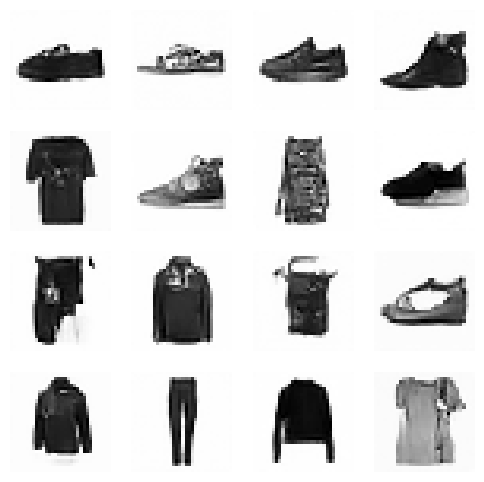

In [98]:
# pretty good for 100 steps - so much faster!
show_images(denorm_image(preds[-1]), imsize=1.5)


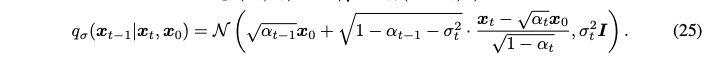

In [102]:
display.Image(
    "images/ddim_dist.png"
)

- aplha in DDPIM is alphabar from DDPM (this is very confusing)
- main difference vs DDPM is this distribution
- there is now a sigma that we can control
- if sigma is 0 then the variance is 0 --> deterministic is optional
- no need to train a different model (as shown above) - but be able to control the stoacsticity
- basically just a "new" sampling algo

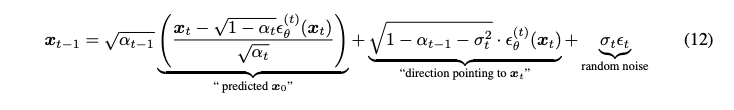

In [104]:
display.Image(
    "images/ddim_sample.png"
)

- predicting x0 (removing all the noise) 
- go back to x_t and optionally add noise 
- slowly going back to the "real image distributiuon" by going into that direction, then go back and add optional noise


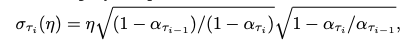

In [103]:
display.Image(
    "images/ddim_eta.png"
)

- if η is set to 1 (eta in diffusers) then this mimicks the DDPM generative process 
- DDPM: no way of controlling how much noise is added back - this added in DDIM
- note the fact that different timesteps receive different amounts of noise

In [105]:
#TODO: get intuition why the accelerated sampling really works